<a href="https://colab.research.google.com/github/Seong-Wany/Mini-PJT/blob/main/Instarcart_EDA_Report.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

오늘은 Kaggle에 Instacart Market Basket Analysis라는 주제에서 Data 분석을 해보겠습니다.
[Instarcart Market Basket Analysis](https://www.kaggle.com/c/instacart-market-basket-analysis)

사실 저는 이 과제가 처음에는 주제나 목표 파악하기가 생각보다 어려웠습니다.(영어라서는 아닙니다?) 아직 제가 익숙하지 못해서 Data 파일에 Prior그룹, Train그룹, Test그룹이 한번에 있다보니 이게 왜 한번에 있지라는 생각이었습니다.

하지만 홈페이지에 Description과 Evaluation을 잘 읽고 Data를 먼저 자세히 보니 파악이 되었습니다. 여러분들도 Data를 불러와서 각 Column들과 Row들을 보면서 분석하도록 해보시길 바랍니다. 물론 Code부분의 다른 Data분석가들의 의견도 많이 참조하였습니다.

 밑에 Data를 살펴보면 orders에 prior, train, test 그룹이 있습니다. prior 그룹의 주문 경향과 train 그룹의 주문 경향이 같은지 다른지 확인을하고 경향이 다르지 않다면 prior 그룹을 통해 구매 경향성을 분석하고 train으로 맞는지 확인 후 추후에 test 그룹 주문을 예측하는 방향으로 가려고 합니다.

In [ ]:
# Data 파일을 불러올 수 있게 Drive mount를 합니다. 
from google.colab import drive
drive.mount('../content/drive')

Mounted at ../content/drive


In [ ]:
#한글 폰트 깨짐 방지
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 2s (5,798 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletyp

In [ ]:
# 필요한 라이브러리 불러오기

# 분석 라이브러리 불러오기
import pandas as pd
import numpy as np
import seaborn as sns
color = sns.color_palette()

%matplotlib inline  

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm  # 폰트 관련 용도

font_list = [font.name for font in fm.fontManager.ttflist]
font_list

plt.rc('font', family='NanumBarunGothic') 
#한글 폰트 사용 때문입니다.

import scipy.stats # 상관계수 분석

메모리 부족해결을 위해 미리 조정할 수 있는 함수를 사용합니다.

In [ ]:
#메모리 부족해결을 위해 미리 조정할 수 있는 함수를 사용합니다.
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        col_type2 = df[col].dtype.name
        
        if ((col_type != object) and (col_type2 != 'category')):
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [ ]:
# order_products_train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/order_products__train.csv', encoding = 'utf-8'))
# order_products_prior = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/order_products__prior.csv', encoding = 'utf-8'))
# orders = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/orders.csv', encoding = 'utf-8'))
# products = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/products.csv', encoding = 'utf-8'))
# aisles = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/aisles.csv', encoding ='utf-8'))
# departments = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/data/departments.csv', encoding = 'utf-8'))

order_products_train = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/order_products__train.csv', encoding = 'utf-8'))
order_products_prior = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/order_products__prior.csv', encoding = 'utf-8'))
orders = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/orders.csv', encoding = 'utf-8'))
products = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/products.csv', encoding = 'utf-8'))
aisles = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/aisles.csv', encoding ='utf-8'))
departments = reduce_mem_usage(pd.read_csv('/content/drive/MyDrive/EDApjtinstarcart/departments.csv', encoding = 'utf-8'))

Memory usage of dataframe is 42.26 MB
Memory usage after optimization is: 13.20 MB
Decreased by 68.7%
Memory usage of dataframe is 989.82 MB
Memory usage after optimization is: 340.25 MB
Decreased by 65.6%
Memory usage of dataframe is 182.71 MB
Memory usage after optimization is: 45.68 MB
Decreased by 75.0%
Memory usage of dataframe is 1.52 MB
Memory usage after optimization is: 2.15 MB
Decreased by -41.8%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.01 MB
Decreased by -201.8%
Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by -110.8%


In [ ]:
order_products_prior.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Non-Null Count     Dtype
---  ------             --------------     -----
 0   order_id           32434489 non-null  int32
 1   product_id         32434489 non-null  int32
 2   add_to_cart_order  32434489 non-null  int16
 3   reordered          32434489 non-null  int8 
dtypes: int16(1), int32(2), int8(1)
memory usage: 340.3 MB


In [ ]:
order_products_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int32
 1   product_id         1384617 non-null  int32
 2   add_to_cart_order  1384617 non-null  int8 
 3   reordered          1384617 non-null  int8 
dtypes: int32(2), int8(2)
memory usage: 13.2 MB


In [ ]:
orders.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype   
---  ------                  --------------    -----   
 0   order_id                3421083 non-null  int32   
 1   user_id                 3421083 non-null  int32   
 2   eval_set                3421083 non-null  category
 3   order_number            3421083 non-null  int8    
 4   order_dow               3421083 non-null  int8    
 5   order_hour_of_day       3421083 non-null  int8    
 6   days_since_prior_order  3214874 non-null  float16 
dtypes: category(1), float16(1), int32(2), int8(3)
memory usage: 45.7 MB


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   product_id     49688 non-null  int32   
 1   product_name   49688 non-null  category
 2   aisle_id       49688 non-null  int16   
 3   department_id  49688 non-null  int8    
dtypes: category(1), int16(1), int32(1), int8(1)
memory usage: 2.2 MB


In [ ]:
aisles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   aisle_id  134 non-null    int16   
 1   aisle     134 non-null    category
dtypes: category(1), int16(1)
memory usage: 6.7 KB


In [ ]:
departments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   department_id  21 non-null     int8    
 1   department     21 non-null     category
dtypes: category(1), int8(1)
memory usage: 978.0 bytes


In [ ]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [ ]:
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [ ]:
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [ ]:
orders.head(50)

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


User ID로 구분되는 열에서 첫주문은 days_since_prior_order가 NaN값입니다. 그리고 마지막 주문 외에는 train 또는 test order항목으로 들어가는 것으로 볼 수 있습니다. 참고해야겠습니다.

In [ ]:
order_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
order_products_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
orders.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3214874.0
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,NaN
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,0.0
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.0
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.0
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,15.0
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,30.0


In [ ]:
orders['eval_set'].value_counts()

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64

In [ ]:
departments.value_counts()

department_id  department     
21             missing            1
10             bulk               1
2              other              1
3              bakery             1
4              produce            1
5              alcohol            1
6              international      1
7              beverages          1
8              pets               1
9              dry goods pasta    1
11             personal care      1
20             deli               1
12             meat seafood       1
13             pantry             1
14             breakfast          1
15             canned goods       1
16             dairy eggs         1
17             household          1
18             babies             1
19             snacks             1
1              frozen             1
dtype: int64

In [ ]:
aisles['aisle'].unique()

['prepared soups salads', 'specialty cheeses', 'energy granola bars', 'instant foods', 'marinades meat preparation', ..., 'hot cereal pancake mixes', 'dry pasta', 'beauty', 'muscles joints pain relief', 'specialty wines champagnes']
Length: 134
Categories (134, object): ['prepared soups salads', 'specialty cheeses', 'energy granola bars',
                           'instant foods', ..., 'dry pasta', 'beauty', 'muscles joints pain relief',
                           'specialty wines champagnes']

orders를 먼저 분석해보겠습니다.
eval_set을 가지고 order_prior, order_train, order_test 로 나누고 각 항목별로 
살펴보겠습니다.

In [ ]:
orders_prior = reduce_mem_usage(orders[orders['eval_set']=='prior'])
orders_train = reduce_mem_usage(orders[orders['eval_set']=='train'])
orders_test = reduce_mem_usage(orders[orders['eval_set']=='test'])
#prior, train, test로 각 Dataframe 생성

Memory usage of dataframe is 67.45 MB
Memory usage after optimization is: 67.45 MB
Decreased by 0.0%
Memory usage of dataframe is 2.75 MB
Memory usage after optimization is: 2.75 MB
Decreased by 0.0%
Memory usage of dataframe is 1.57 MB
Memory usage after optimization is: 1.57 MB
Decreased by 0.0%


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

### order에 관한 분석
① 주문별 아이템 수 확인
- prior

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


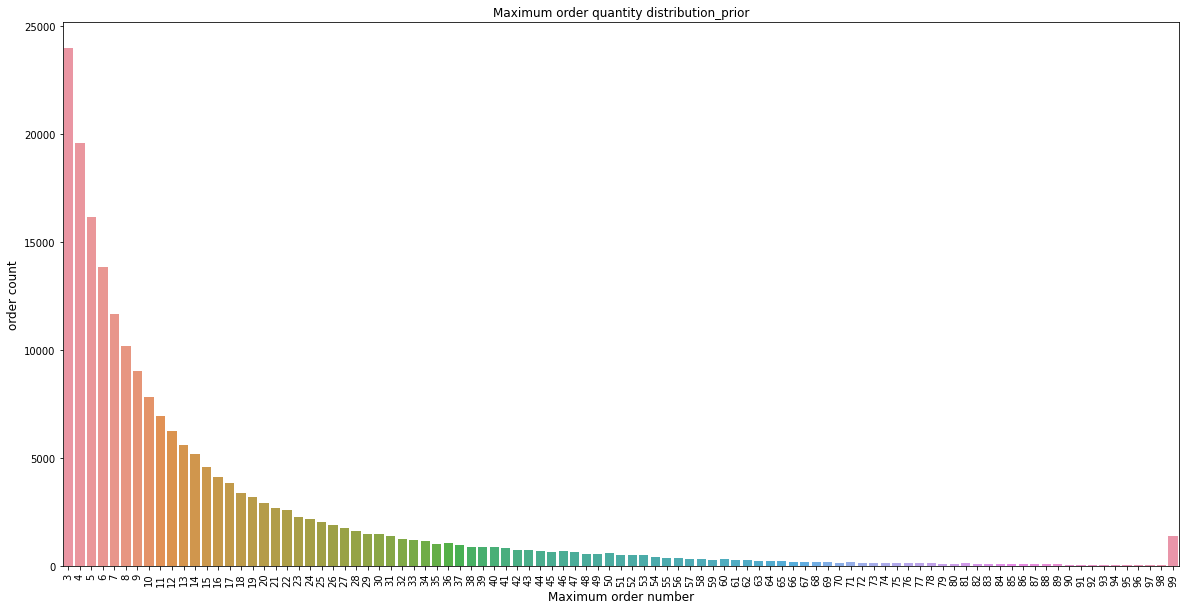

In [ ]:
max_prior = orders_prior.groupby("user_id")["order_number"].max().reset_index()
max_prior = max_prior.order_number.value_counts()

plt.figure(figsize=(20,10))
sns.barplot(max_prior.index, max_prior.values)
plt.ylabel('order count', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Maximum order quantity distribution_prior')
plt.show()

- train

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


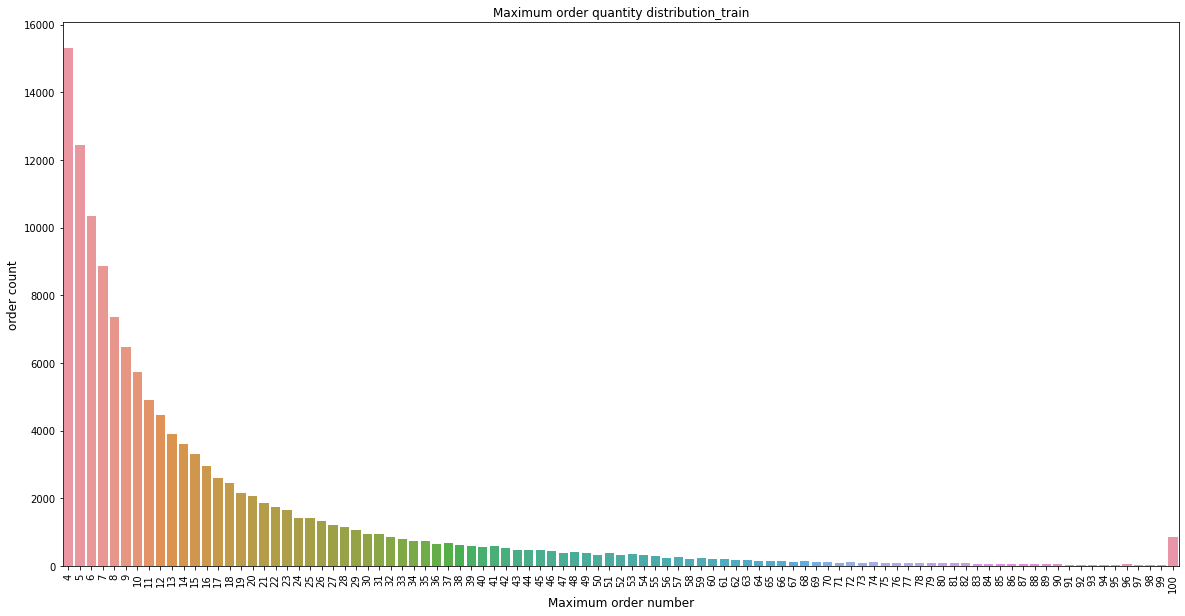

In [ ]:
max_train = orders_train.groupby("user_id")["order_number"].max().reset_index()
max_train = max_train.order_number.value_counts()

plt.figure(figsize=(20,10))
sns.barplot(max_train.index, max_train.values)
plt.ylabel('order count', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.title('Maximum order quantity distribution_train')
plt.show()

prior와 train에서 4개를 주문한 user들이 많습니다. 특이하게 99 ~ 100개를 주문한 user가 갑자기 많아지는 특성이 있습니다.

In [ ]:
orders_prior.sort_values(by= 'order_number', ascending = False).head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
2070683,3115226,124477,prior,99,4,10,1.0
1616005,1219095,97013,prior,99,5,13,3.0
1334889,2092292,80189,prior,99,3,10,2.0
2438112,1613683,146714,prior,99,6,13,2.0
2948052,1610072,177893,prior,99,3,10,1.0


In [ ]:
orders_train.sort_values(by= 'order_number', ascending = False).head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
2830211,2935255,170746,train,100,6,7,1.0
3022712,2391974,182401,train,100,0,20,1.0
1660942,598764,99721,train,100,1,20,1.0
2851339,1750101,172039,train,100,3,14,2.0
1373722,2209627,82545,train,100,4,13,1.0


② 요일별 주문수 확인
- prior

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


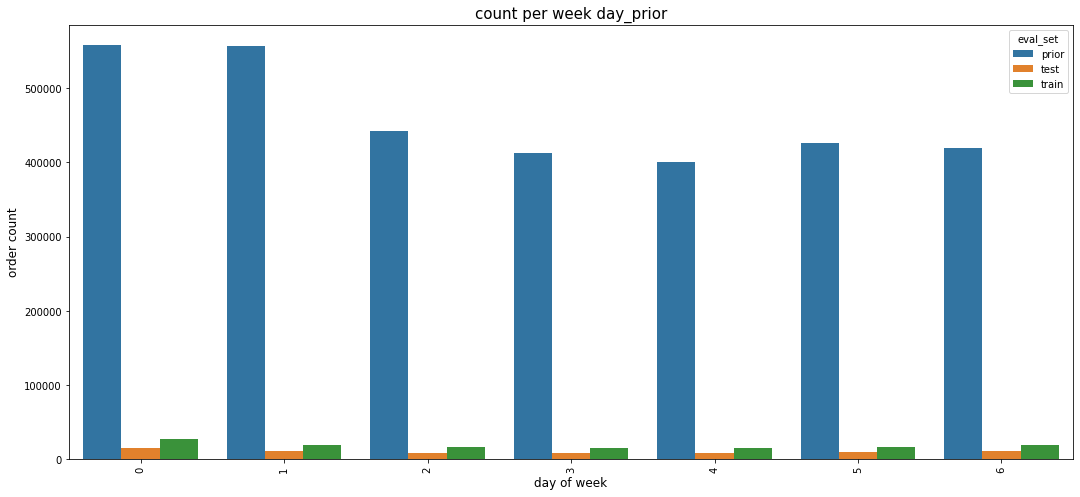

In [ ]:
plt.figure(figsize=(18,8))
sns.countplot(data=orders, x="order_dow", hue="eval_set")
plt.ylabel('order count', fontsize=12)
plt.xlabel('day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("count per week day_prior", fontsize=15)
plt.show()

Data 수량이 차이나서 보기 어려우므로 따로 따로 확인하겠습니다.

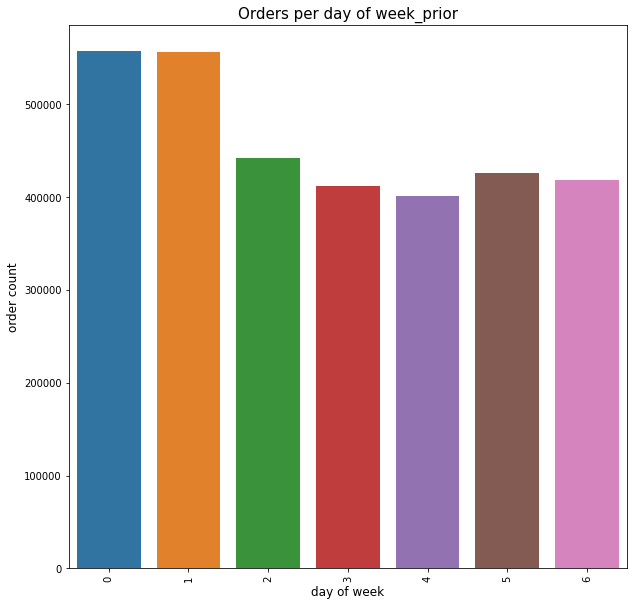

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(data=orders_prior, x="order_dow")
plt.ylabel('order count', fontsize=12)
plt.xlabel('day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Orders per day of week_prior", fontsize=15)
plt.show()

- 요일별 주문수 확인(train)

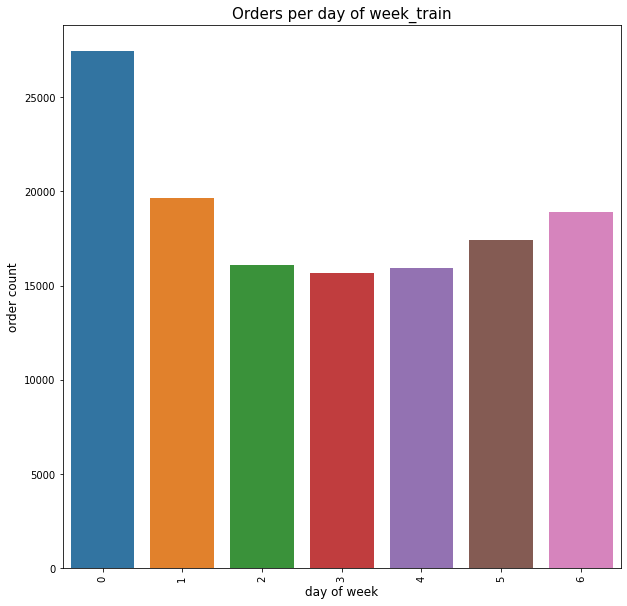

In [ ]:
plt.figure(figsize=(10,10))
sns.countplot(data=orders_train, x="order_dow")
plt.ylabel('order count', fontsize=12)
plt.xlabel('day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Orders per day of week_train", fontsize=15)
plt.show()

둘다 0번 요일에 주문수가 많고 1번 요일은 차이가 나지만 0, 1에 주문이 몰려있다는데에 유사점이 있습니다.

③ 하루 시간별 주문수 확인
- prior

Text(0.5, 1.0, 'Orders per day of week_prior')

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


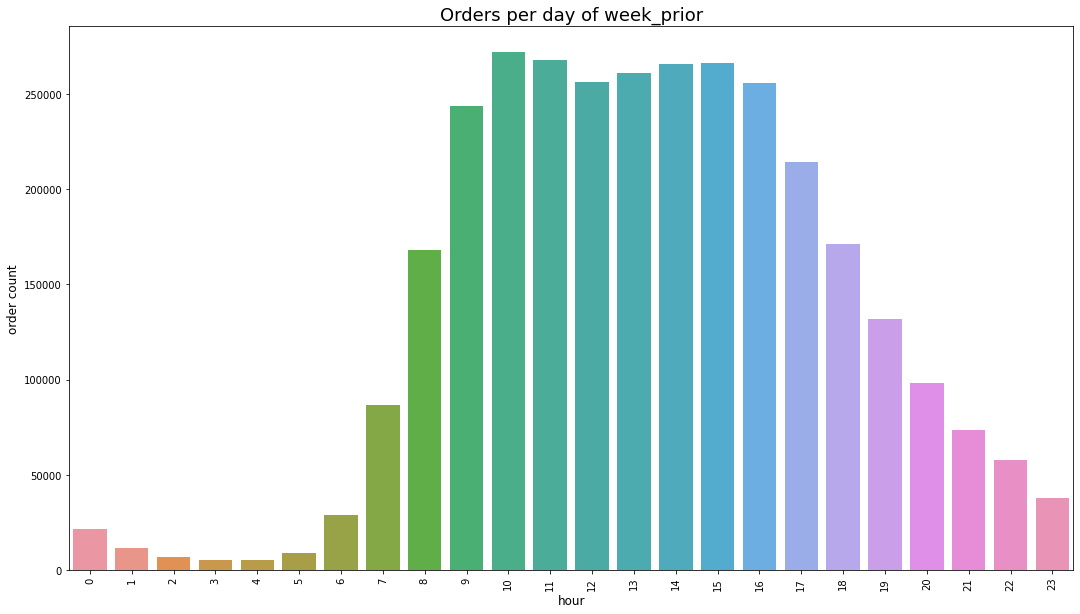

In [ ]:
plt.figure(figsize=(18,10))
sns.countplot(data = orders_prior, x = "order_hour_of_day")
plt.ylabel('order count', fontsize = 12)
plt.xlabel('hour', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Orders per day of week_prior", fontsize = 18)

- Train

Text(0.5, 1.0, 'Orders per day of week_prior')

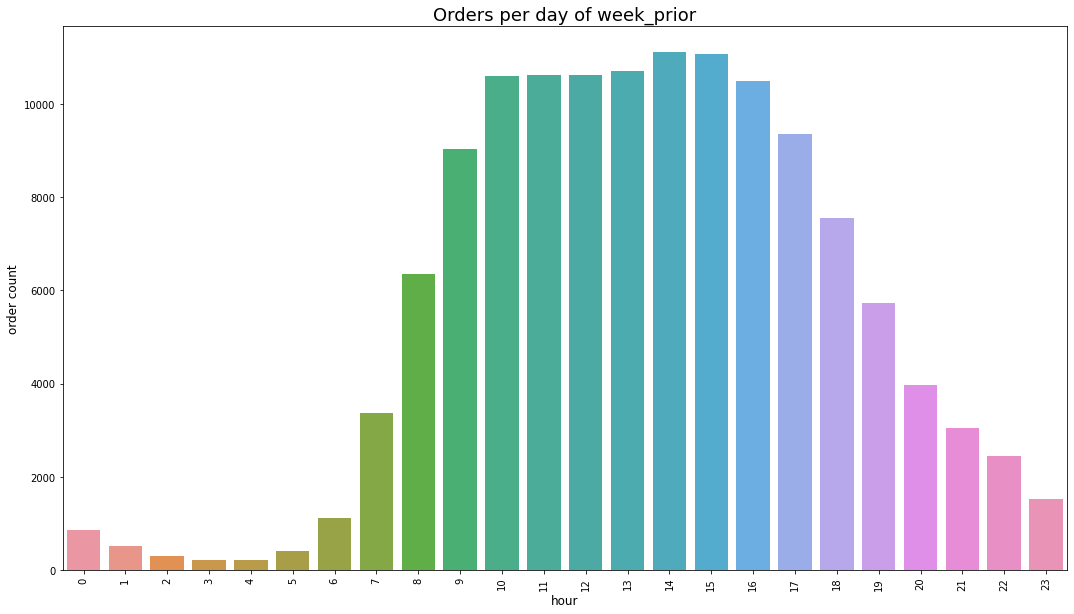

In [ ]:
plt.figure(figsize=(18,10))
sns.countplot(data = orders_train, x = "order_hour_of_day")
plt.ylabel('order count', fontsize = 12)
plt.xlabel('hour', fontsize = 12)
plt.xticks(rotation = 'vertical')
plt.title("Orders per day of week_prior", fontsize = 18)

④ 요일별, 시간대별 분포 확인(prior/train)
- prior

In [ ]:
confirm_prior = pd.pivot_table(data=orders_prior,
                              index=["order_dow"],
                              columns = ["order_hour_of_day"],
                              aggfunc = {"order_id" : "count"}
                              )  # aggfunc={"order_id", : "count", "price" : "sum"}
confirm_prior    

order_id                   ...                           
order_hour_of_day       0     1     2    3   ...     20     21     22    23
order_dow                                    ...                           
0                     3692  2235  1299  888  ...  16984  13425  10440  6393
1                     3475  1735  1063  711  ...  15422  11292   8458  5322
2                     2906  1485   892  679  ...  14223  10071   7671  5079
3                     2767  1407   889  605  ...  13064   9718   7732  4895
4                     2476  1414   837  640  ...  13351  10169   8274  5308
5                     2989  1539   953  796  ...  12557   8956   7006  4953
6                     3067  1781  1137  801  ...  12508   9805   7959  5663

[7 rows x 24 columns]

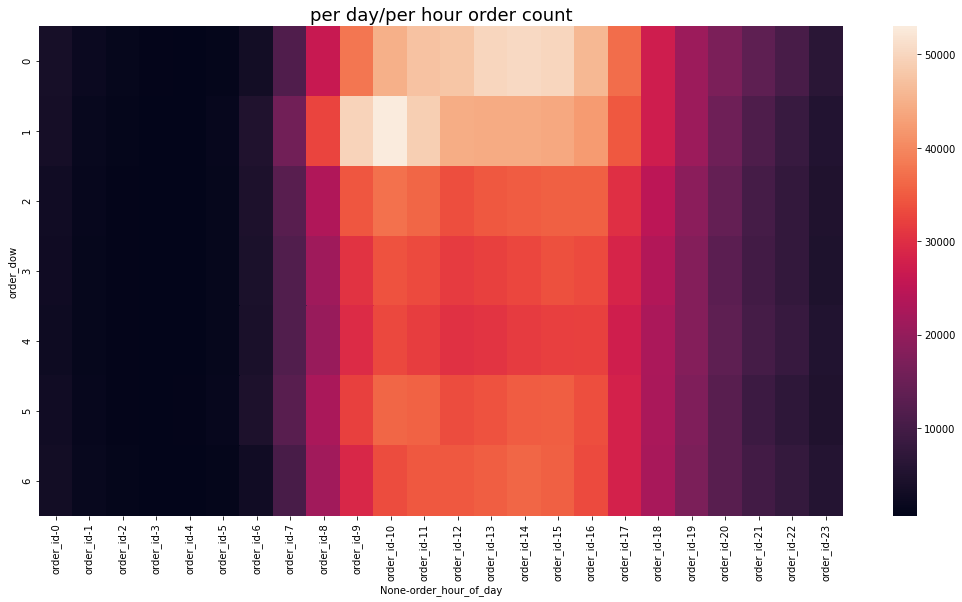

In [ ]:
plt.figure(figsize = (18,9))
sns.heatmap(confirm_prior)
plt.title('per day/per hour order count', fontsize=18)
plt.show()

- train

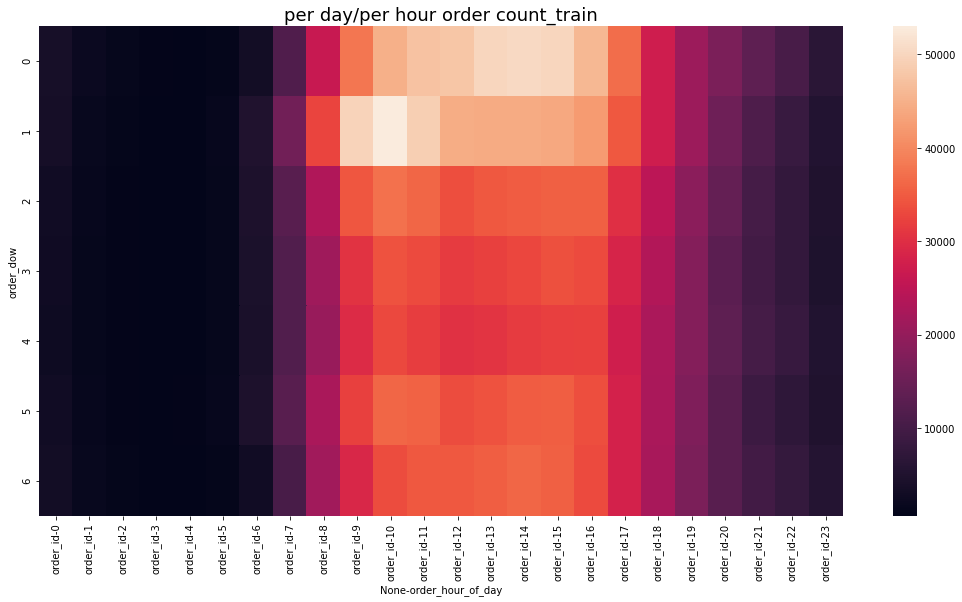

In [ ]:
confirm_train = pd.pivot_table(data=orders_train,
                              index=["order_dow"],
                              columns = ["order_hour_of_day"],
                              aggfunc = {"order_id" : "count"}
                              )  # aggfunc={"order_id", : "count", "price" : "sum"}
plt.figure(figsize = (18,9))
sns.heatmap(confirm_prior)
plt.title('per day/per hour order count_train', fontsize=18)
plt.show()

⑤ 재주문까지 시간 확인
- prior

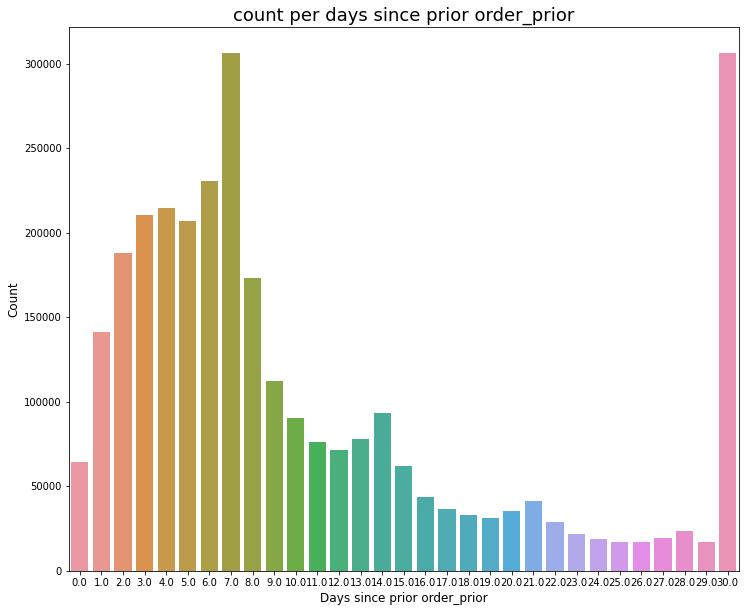

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(data=orders_prior, x="days_since_prior_order")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order_prior', fontsize=12)
plt.title("count per days since prior order_prior", fontsize=18)
plt.show()

- train

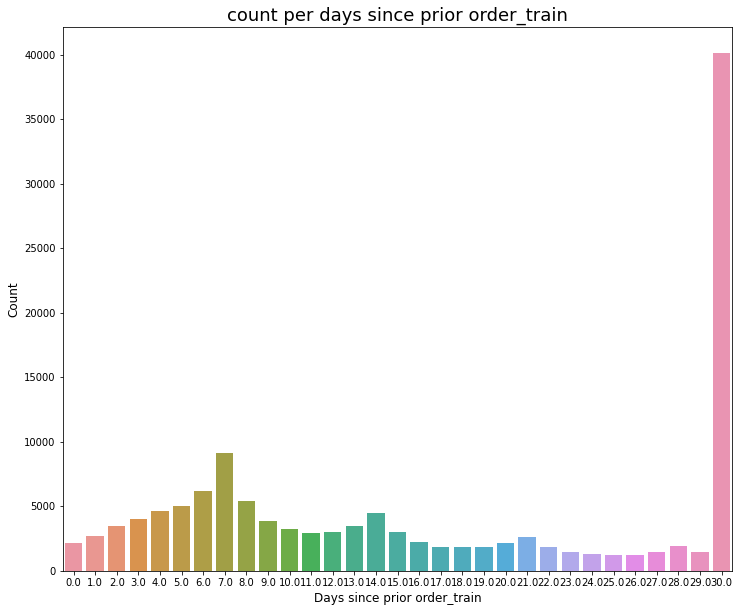

In [ ]:
plt.figure(figsize=(12,10))
sns.countplot(data=orders_train, x="days_since_prior_order")
plt.ylabel('Count', fontsize=12)
plt.xlabel('Days since prior order_train', fontsize=12)
plt.title("count per days since prior order_train", fontsize=18)
plt.show()

prior 그룹은 7일째와 30일째에 재주문이 많은데 train 그룹은 30째가 유독 많고 그다음 7일째에 재주문이 많은 분포를 보입니다.
이제 아이템별 재주문에 대해 분석하는데 참조하면 좋겠습니다.

### product 구매에 관한 분석

이제 product 구매에 관한 데이터 분석을 하려고 합니다.

앞서서 order data를 분석했을 때 prior와 train order의 구매 습성은 어느정도 유사해보입니다. 

이제 여기서 Product에 대한 구매에 대해서도 유사함을 보인다면, 여기서의 구매특성을 가지고 test에 적용하여 test 오더에 추천할만한 상품들을 알 수 있겠다라는 생각이 듭니다.

① prior 그룹의 재구매율, train 그룹의 재구매율

In [ ]:
A_prior = order_products_prior.reordered.sum() / order_products_prior.shape[0] * 100
B_train = order_products_train.reordered.sum() / order_products_train.shape[0] * 100
print("prior 재구매율 ", A_prior, "// train 재구매율 ", B_train)

prior 재구매율  58.969746679221615 // train 재구매율  59.859441275096295


둘의 재구매율은 값이 비슷합니다.
이제 여기서부터는 Product에 prior order의 product 구매 특성을 먼저 분석하고 그것으로 train order에 예측을 적용하고 비교해봤을때 내용이 타당성이 있다면 test에 적용하는 방식으로 진행하고자 합니다.
그래서 먼저 prior order를 분석하겠습니다.

② 재주문이 많은 상품 구하기
재구매가 많이 발생한 상품을 구하기 위해 product ID 별로 reorder를 group by 합계를 구하고 product ID로 제품을 추적하겠습니다.

In [ ]:
order_products_prior_df = reduce_mem_usage(pd.merge(order_products_prior, products, on = "product_id", how="left"))
order_products_prior_df = reduce_mem_usage(pd.merge(order_products_prior_df, aisles, on = "aisle_id", how="left"))
order_products_prior_df = reduce_mem_usage(pd.merge(order_products_prior_df, departments, on = "department_id", how="left"))
order_products_prior_df.head(20)

Memory usage of dataframe is 805.86 MB
Memory usage after optimization is: 805.86 MB
Decreased by 0.0%
Memory usage of dataframe is 867.73 MB
Memory usage after optimization is: 867.73 MB
Decreased by 0.0%
Memory usage of dataframe is 898.66 MB
Memory usage after optimization is: 898.66 MB
Decreased by 0.0%


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry
5,2,17794,6,1,Carrots,83,4,fresh vegetables,produce
6,2,40141,7,1,Original Unflavored Gelatine Mix,105,13,doughs gelatins bake mixes,pantry
7,2,1819,8,1,All Natural No Stir Creamy Almond Butter,88,13,spreads,pantry
8,2,43668,9,0,Classic Blend Cole Slaw,123,4,packaged vegetables fruits,produce
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs


In [ ]:
# product별 prior 재주문수
reorder_prior = order_products_prior_df.groupby('product_name')['reordered'].sum().reset_index()
reorder_prior

,product_name,reordered
0,#2 Coffee Filters,257.0
1,#2 Cone White Coffee Filters,3.0
2,#2 Mechanical Pencils,0.0
3,#4 Natural Brown Coffee Filters,89.0
4,& Go! Hazelnut Spread + Pretzel Sticks,87.0
...,...,...
49683,with Xylitol Unwrapped Original Flavor 50 Stic...,17.0
49684,with Xylitol Unwrapped Spearmint 50 Sticks Sug...,19.0
49685,with Xylitol Watermelon Twist 18 Sticks Sugar ...,31.0
49686,with a Splash of Mango Coconut Water,6.0


어떤 상품이 재구매가 많이 일어나는지 20위 정도까지 확인해보겠습니다.

In [ ]:
reorder_prior = reorder_prior.sort_values(by = 'reordered', ascending=False)
reorder_prior.head(20)

,product_name,reordered
3677,Banana,398609.0
3472,Bag of Organic Bananas,315913.0
31923,Organic Strawberries,205845.0
28843,Organic Baby Spinach,186884.0
30300,Organic Hass Avocado,170131.0
28807,Organic Avocado,134044.0
32481,Organic Whole Milk,114510.0
22415,Large Lemon,106255.0
31366,Organic Raspberries,105409.0
42910,Strawberries,99802.0


바나나랑 Organic이 많이 보이는데 한번 Department로 정리해보겠습니다.

In [ ]:
reorder_department = order_products_prior_df.groupby('department')['reordered'].sum().reset_index().sort_values(by='reordered', ascending = False).reset_index().drop(columns = ['index'], axis =1)

reorder_department

,department,reordered
0,produce,6160710.0
1,dairy eggs,3627221.0
2,beverages,1757892.0
3,snacks,1657973.0
4,frozen,1211890.0
5,bakery,739188.0
6,pantry,650301.0
7,deli,638864.0
8,canned goods,488535.0
9,meat seafood,402442.0


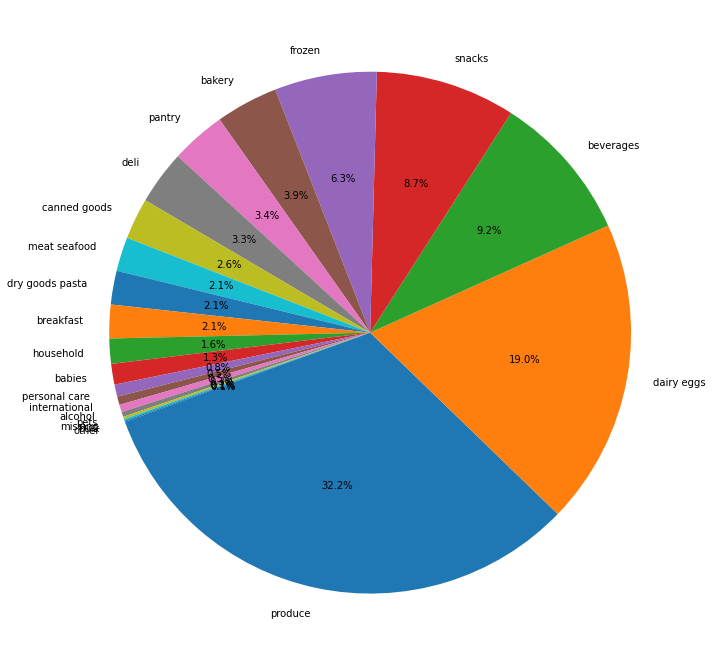

In [ ]:
plt.figure(figsize=(12,12))
pro_reorder = np.array(reorder_department['reordered'] / 19126536 * 100)  # 19126536은 prior 그룹의 reorder의 총 갯수
plt.pie(pro_reorder, labels = reorder_department['department'], startangle = 200, autopct='%1.1f%%')
plt.show()

전체 재주문수 대비 재주문 순위를 봤는데 혹시 상품 자체 판매량 대비 재주문율 순위는 어떤지 살펴 보겠습니다. 먼저 판매량 순위입니다.

In [ ]:
cnt_product_prior = order_products_prior_df['product_name'].value_counts().sort_values(ascending=False).reset_index() # 판매량 수 대로 먼저 내림차순 정렬
cnt_product_prior

,index,product_name
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
...,...,...
49683,Sweetart Jelly Beans,0
49684,Non-Dairy Coconut Seven Layer Bar,0
49685,Single Barrel Kentucky Straight Bourbon Whiskey,0
49686,Water With Electrolytes,0


In [ ]:
cnt_product_prior.rename(columns = {'index' : 'product_name','product_name' : 'order_cnt'}, inplace = True) # index를 변경
cnt_product_prior

,product_name,order_cnt
0,Banana,472565
1,Bag of Organic Bananas,379450
2,Organic Strawberries,264683
3,Organic Baby Spinach,241921
4,Organic Hass Avocado,213584
...,...,...
49683,Sweetart Jelly Beans,0
49684,Non-Dairy Coconut Seven Layer Bar,0
49685,Single Barrel Kentucky Straight Bourbon Whiskey,0
49686,Water With Electrolytes,0


In [ ]:
reorder_ratio = reduce_mem_usage(pd.merge(reorder_prior, cnt_product_prior, on = "product_name", how="left"))

Memory usage of dataframe is 2.96 MB
Memory usage after optimization is: 2.58 MB
Decreased by 12.8%


합체가 잘되었는지 확인합니다.

In [ ]:
reorder_ratio.sort_index(ascending = True).head(20)

,product_name,reordered,order_cnt
0,Banana,398609.0,472565
1,Bag of Organic Bananas,315913.0,379450
2,Organic Strawberries,205845.0,264683
3,Organic Baby Spinach,186884.0,241921
4,Organic Hass Avocado,170131.0,213584
5,Organic Avocado,134044.0,176815
6,Organic Whole Milk,114510.0,137905
7,Large Lemon,106255.0,152657
8,Organic Raspberries,105409.0,137057
9,Strawberries,99802.0,142951


판매량 대비 재주문율 순위입니다.

In [ ]:
reorder_ratio['reorder_ratio'] = reorder_ratio['reordered'] / reorder_ratio['order_cnt'] * 100 
# 판매량 대비 재주문율
reorder_ratio.sort_values(by = 'reorder_ratio', ascending = False).head(50)
# 판매량 대비 재주문 순위

,product_name,reordered,order_cnt,reorder_ratio
16342,Raw Veggie Wrappers,64.0,68,94.117645
14738,Serenity Ultimate Extrema Overnight Pads,81.0,87,93.103447
29723,Orange Energy Shots,12.0,13,92.307693
13795,Chocolate Love Bar,93.0,101,92.079208
21728,Soy Powder Infant Formula,32.0,35,91.428574
19733,Simply Sleep Nighttime Sleep Aid,41.0,45,91.111115
25442,"Energy Shot, Grape Flavor",20.0,22,90.909096
22961,Russian River Valley Reserve Pinot Noir,27.0,30,90.000000
14011,Maca Buttercups,90.0,100,90.000000
17698,Sparking Water,54.0,60,90.000000


재구매수량, 판매수량과는 완전히 다르게 상품들의 재구매율 순위는 다릅니다. 이것을 department 별로 확인하여 시각화해보겠습니다.

In [ ]:
cnt_department_prior = order_products_prior_df['department'].value_counts().sort_values(ascending=False).reset_index()
cnt_department_prior.rename(columns = {'index' : 'department','department' : 'dep_order_cnt'}, inplace = True)
cnt_department_prior

,department,dep_order_cnt
0,produce,9479291
1,dairy eggs,5414016
2,snacks,2887550
3,beverages,2690129
4,frozen,2236432
5,pantry,1875577
6,bakery,1176787
7,canned goods,1068058
8,deli,1051249
9,dry goods pasta,866627


In [ ]:
dep_reorder_ratio = reduce_mem_usage(pd.merge(reorder_department, cnt_department_prior, on = "department", how="left"))
dep_reorder_ratio

Memory usage of dataframe is 0.00 MB
Memory usage after optimization is: 0.00 MB
Decreased by 12.6%


,department,reordered,dep_order_cnt
0,produce,6160710.0,9479291
1,dairy eggs,3627221.0,5414016
2,beverages,1757892.0,2690129
3,snacks,1657973.0,2887550
4,frozen,1211890.0,2236432
5,bakery,739188.0,1176787
6,pantry,650301.0,1875577
7,deli,638864.0,1051249
8,canned goods,488535.0,1068058
9,meat seafood,402442.0,708931


In [ ]:
dep_reorder_ratio['reorder_ratio'] = dep_reorder_ratio['reordered'] / dep_reorder_ratio['dep_order_cnt'] * 100

department별 재주문율 순위입니다.

In [ ]:
dep_reorder_ratio
# depratment별 재주문율 순위

,department,reordered,dep_order_cnt,reorder_ratio
0,produce,6160710.0,9479291,64.991253
1,dairy eggs,3627221.0,5414016,66.996865
2,beverages,1757892.0,2690129,65.346011
3,snacks,1657973.0,2887550,57.417984
4,frozen,1211890.0,2236432,54.188547
5,bakery,739188.0,1176787,62.814086
6,pantry,650301.0,1875577,34.672050
7,deli,638864.0,1051249,60.771901
8,canned goods,488535.0,1068058,45.740493
9,meat seafood,402442.0,708931,56.767443


findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


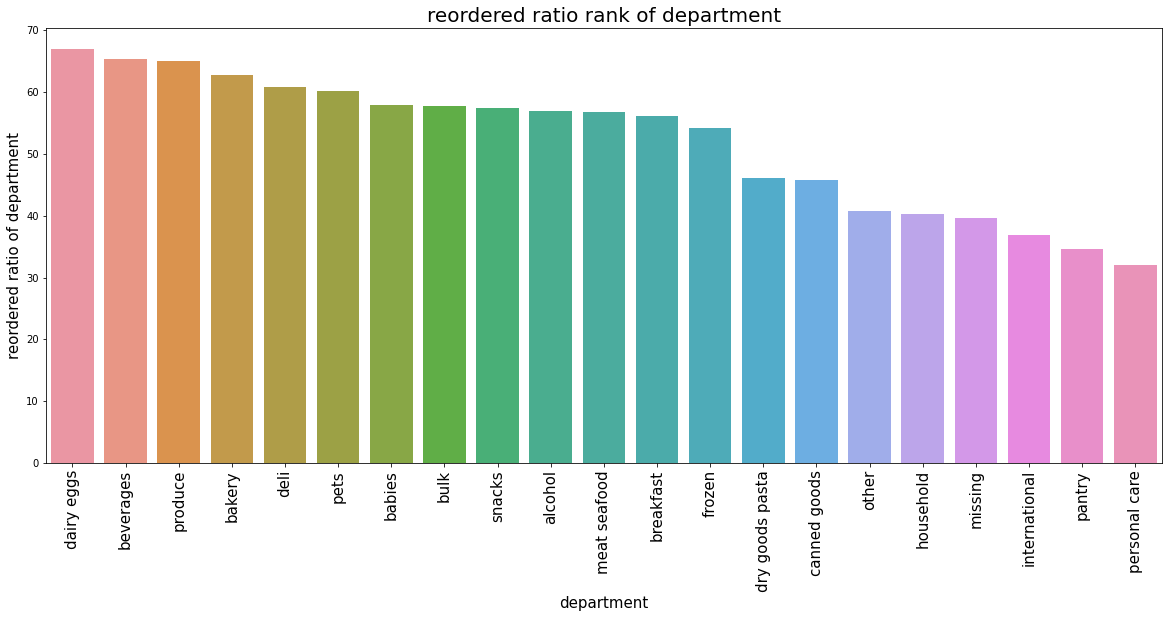

In [ ]:
# bar 차트로 시각화
exm = dep_reorder_ratio.pivot_table(index = "department", values = "reorder_ratio").sort_values(by = "reorder_ratio", ascending = False)
exm
plt.figure(figsize=(20,8))
sns.barplot(data = exm, x= np.array(exm.index), y="reorder_ratio") # 내림차순하려고 만들어줌
plt.xlabel('department', fontsize =15)
plt.ylabel('reordered ratio of department', fontsize = 15)
plt.xticks(fontsize = 15, rotation ='vertical')
plt.title("reordered ratio rank of department", fontsize = 20)
plt.show()

③ 판매량 또는 재구매율과 카트에 담기는 순서

카트에 담기는 순서가 빠른 제품이 높은 판매량이나 재구매율을 보이는지 한번 확인해보겠습니다.

In [ ]:
# 카트에 담기는 순서가 첫번째인 상품들만 골라냅니다.
first_order_prior = order_products_prior_df.loc[order_products_prior_df["add_to_cart_order"] == 1]
first_order_prior

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs
9,3,33754,1,1,Total 2% with Strawberry Lowfat Greek Strained...,120,16,yogurt,dairy eggs
17,4,46842,1,0,Plain Pre-Sliced Bagels,93,3,breakfast bakery,bakery
30,5,13176,1,1,Bag of Organic Bananas,24,4,fresh fruits,produce
56,6,40462,1,0,Cleanse,31,7,refrigerated,beverages
...,...,...,...,...,...,...,...,...,...
32434455,3421079,30136,1,0,Moisture Soap,25,11,soap,personal care
32434456,3421080,27845,1,1,Organic Whole Milk,84,16,milk,dairy eggs
32434465,3421081,38185,1,0,Hint of Lime Flavored Tortilla Chips,107,19,chips pretzels,snacks
32434472,3421082,17279,1,1,Fresh 99% Lean Ground Turkey,49,12,packaged poultry,meat seafood


In [ ]:
first_order_prior_df = first_order_prior.groupby('product_name')['order_id'].count().reset_index().sort_values(by='order_id', ascending = False).reset_index().drop(columns = ['index'], axis =1)
first_order_prior_df.rename(columns = {'order_id' : 'first pick'}, inplace = True)
first_order_prior_df.head(20)

,product_name,first pick
0,Banana,110916
1,Bag of Organic Bananas,78988
2,Organic Whole Milk,30927
3,Organic Strawberries,27975
4,Organic Hass Avocado,24116
5,Organic Baby Spinach,23543
6,Organic Avocado,22398
7,Spring Water,16822
8,Strawberries,16366
9,Organic Raspberries,14393


1번으로 담기는 순서는 재구매율 보다는 판매량을 따라가는 것으로 보입니다.

재주문율과 판매량, 재주문량, 1번으로 담기는 순위가 관계가 있는지 확인해보겠습니다.

In [ ]:
corr_reorder_first = reduce_mem_usage(pd.merge(reorder_ratio,first_order_prior_df, on = "product_name", how = "left"))

Memory usage of dataframe is 3.15 MB
Memory usage after optimization is: 2.86 MB
Decreased by 9.0%


In [ ]:
corr_reorder_first.describe()

,reordered,order_cnt,reorder_ratio,first pick
count,49688.000000,49688.000000,49677.00000,49688.000000
mean,384.898895,652.763021,inf,64.701216
std,3600.562012,4791.593779,20.81250,749.337447
min,0.000000,0.000000,0.00000,0.000000
25%,4.000000,17.000000,20.81250,1.000000
50%,22.000000,60.000000,37.65625,5.000000
75%,115.000000,260.000000,52.93750,22.000000
max,398609.000000,472565.000000,94.12500,110916.000000


In [ ]:
corr = corr_reorder_first.corr()
corr

,reordered,order_cnt,reorder_ratio,first pick
reordered,1.000000,0.991429,0.134388,0.935343
order_cnt,0.991429,1.000000,0.146157,0.898787
reorder_ratio,0.134388,0.146157,1.000000,0.107394
first pick,0.935343,0.898787,0.107394,1.000000


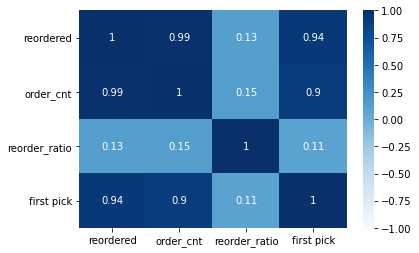

In [ ]:
sns.heatmap(corr,
           annot = True, #실제 값 화면에 나타내기
           cmap = 'Blues', #색상
           vmin = -1, vmax=1)

- 재주문량과 판매량, 카트에 첫번째로 담기는 순위는 상관관계가 있습니다.

- 재주문률과 재주문률은 상관관계가 적습니다.

- 재주문률과 판매량은 상관관계가 적습니다.

- 재주문률과 카트에 첫번째로 담기는 순위도 상관관계가 적습니다.



3) 내용 정리
① prior order와 train order의 주문은 유사성이 보입니다.

② prior order와 train order의 재주문율은 60% 수준입니다. (prior = 58.96 %, train = 59.86%)

③ prior order의 제품별 판매량, 재주문량, 카트에 담기는 순서, 재주문율 순위를 확인하였습니다.

④ 제품별 판매량, 재주문량, 카트에 담기는 순서는 재주문률과는 큰 관계가 없습니다.

⑤ test 고객에게 추천할 상품은 복합적인 고려가 필요할 것으로 생각합니다.

   아래는 1차적인 생각입니다.

   - 먼저, 판매량이 높은 제품을 추천한다.

   - 재주문율이 높은 상품을 구매한 적이 있는 고객에게는 재주문율이 높은 상품을 추천한다.

   - test 고객이 주문하는 요일을 고려하여 재주문율이 높은 제품을 추천한다.

